In [160]:
import multiprocessing as mp
import pickle
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import pandas as pd
import corner

import camb
import clik

In [72]:
# data_path = "planck_chains_run1.pkl"
# data_path = "planck_chains_run2.pkl"
# data_path = "planck_chains_run2_run3.pkl"
# data_path = "planck_chains_run2_run3.pkl"
data_path = "planck_chains_run5.pkl"

with open(data_path, "rb") as f:
    data = pickle.load(f)

chains = data["samples"]
log_likelihoods = data["log_likelihoods"]
accept_rates = data["accept_rates"]

print(accept_rates, np.mean(accept_rates))

(0.249, 0.248, 0.2503, 0.2546, 0.2444) 0.24925999999999998


In [73]:
def gelman_rubin(chains): 
    n_chains = len(chains)
    n_samples = len(chains[0])
    chain_means = np.mean(chains, axis=1)
    grand_mean = np.mean(chain_means, axis=0)
    B = n_samples / (n_chains - 1) * np.diag((chain_means - grand_mean).T @ (chain_means - grand_mean))
    W = np.mean(np.var(chains, axis=1, ddof=1), axis=0)

    return ((n_samples - 1)/n_samples * W + B / n_samples) / W

gelman_rubin(chains)

array([1.00200806, 1.0024463 , 1.00090034, 1.00089924, 1.00076981,
       1.00118641])

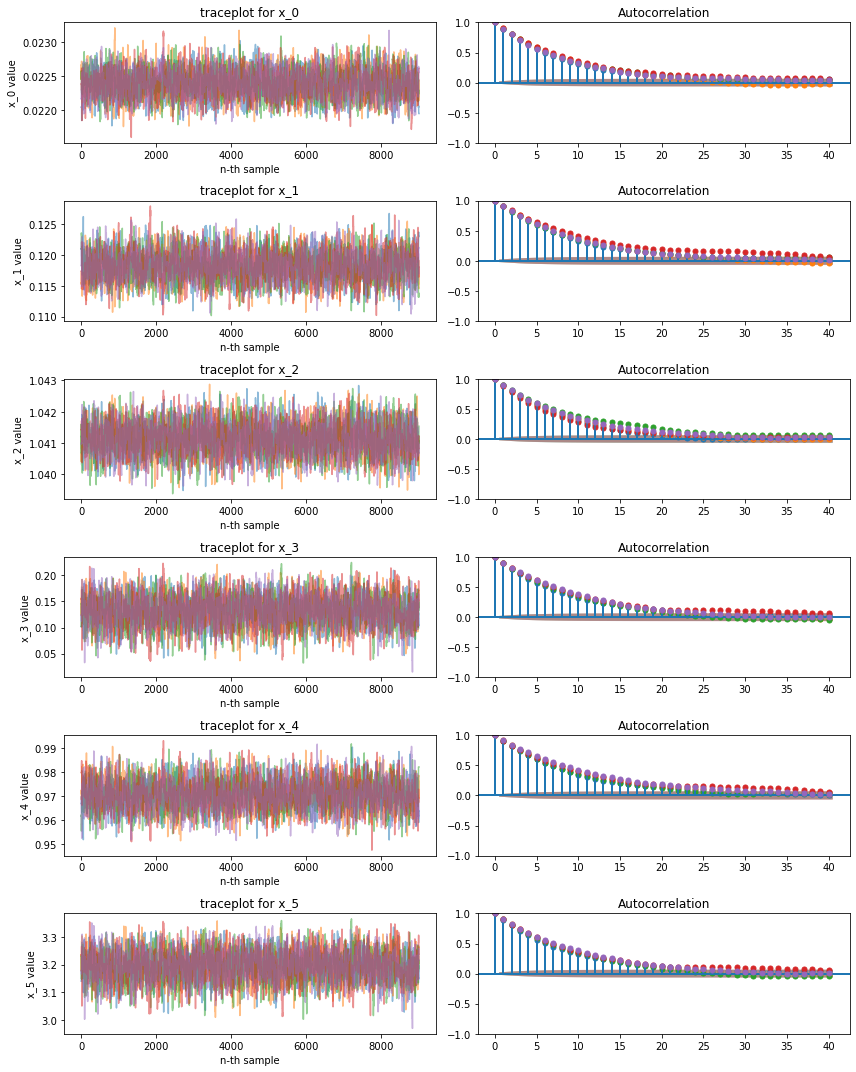

In [69]:
fig, ax = plt.subplots(6, 2, figsize=(12, 15))
for i in range(6):
    for chain in chains: 
        ax[i, 0].plot(np.arange(chain.shape[0]), chain[:, i], alpha=0.5) # plot the trace plot for x_1
        ax[i, 0].set_xlabel('n-th sample') # set x-axis label
        ax[i, 0].set_ylabel(f'x_{i} value') # set y-axis label
        ax[i, 0].set_title(f'traceplot for x_{i}') # set the title

        plot_acf(chain[:, i], ax=ax[i, 1])

plt.tight_layout() # layout the subplots nicely
plt.show() # display the figure

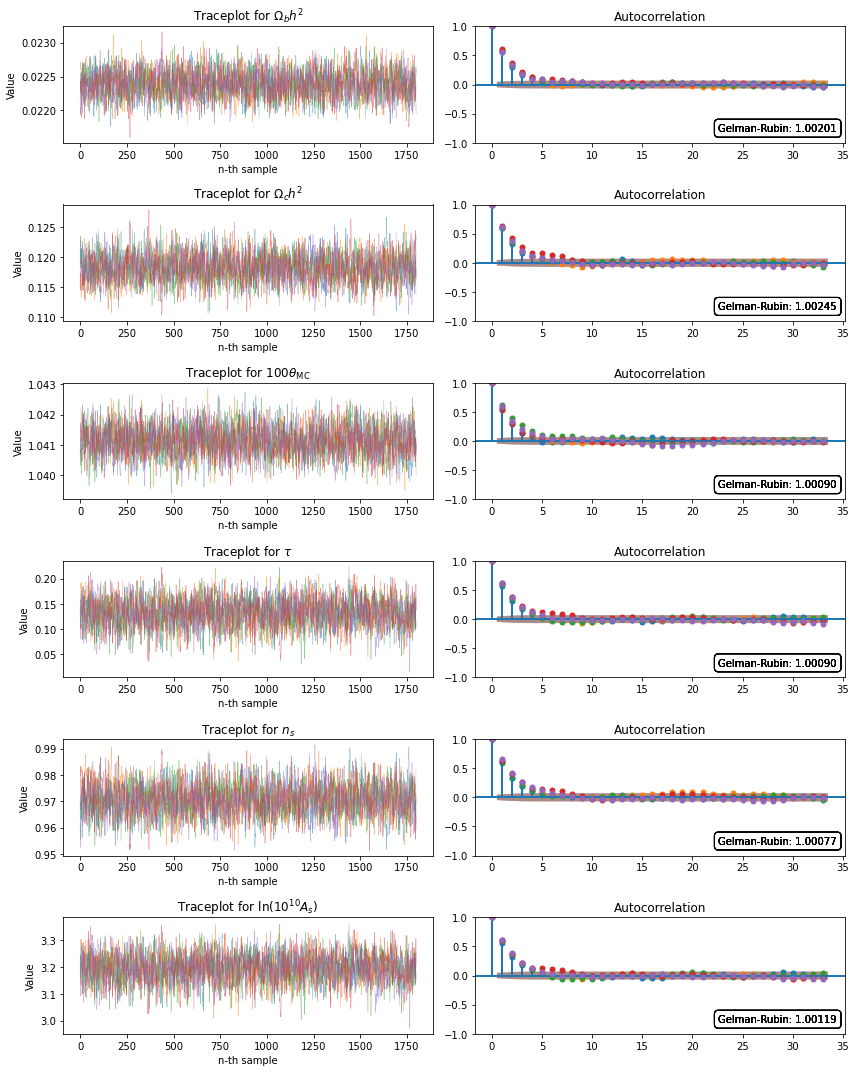

In [89]:
# thin
labels = [r"$\Omega_b h^2$", r"$\Omega_c h^2$", r"$100\theta_\mathrm{MC}$", r"$\tau$", r"$n_s$", r"$\ln(10^{10}A_s)$"]
thinned_chains = [chain[::5] for chain in chains]

fig, ax = plt.subplots(6, 2, figsize=(12, 15))
for i, label, gr_score in zip(range(6), labels, gelman_rubin(chains)):
    for chain in thinned_chains: 
        ax[i, 0].plot(np.arange(chain.shape[0]), chain[:, i], alpha=0.5, lw=0.5) # plot the trace plot for x_1
        ax[i, 0].set_xlabel('n-th sample') # set x-axis label
        ax[i, 0].set_ylabel(f'Value') # set y-axis label
        ax[i, 0].set_title(f'Traceplot for {label}') # set the title

        plot_acf(chain[:, i], ax=ax[i, 1])
        ax[i, 1].text(28.5, -0.75, s=f"Gelman-Rubin: {gr_score:.5f}", horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.4'))

plt.tight_layout() # layout the subplots nicely
plt.savefig("planck_diagnostics_run5_thinned5.pdf")
plt.show() # display the figure

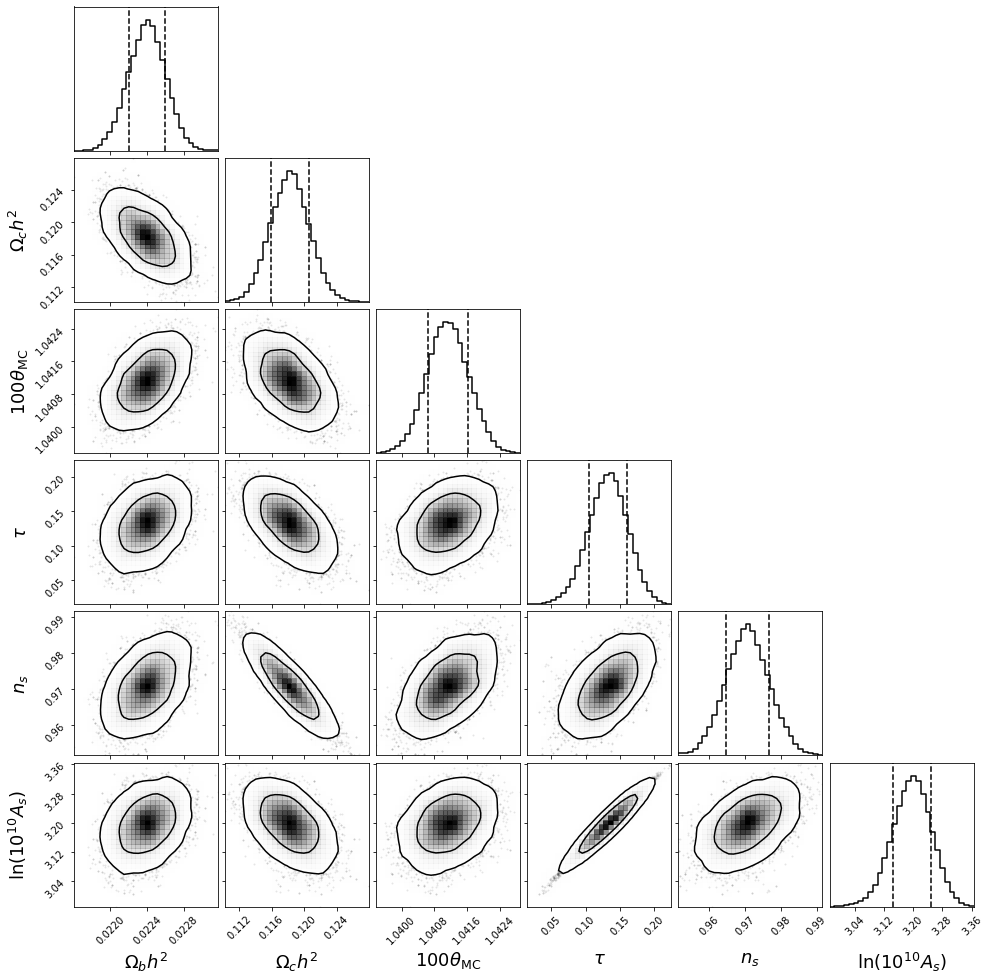

In [71]:
labels = [r"$\Omega_b h^2$", r"$\Omega_c h^2$", r"$100\theta_\mathrm{MC}$", r"$\tau$", r"$n_s$", r"$\ln(10^{10}A_s)$"]
fig = corner.corner(np.vstack(thinned_chains), bins=30, smooth=1, smooth1d=1, labels=labels, label_kwargs={"fontsize": 18}, quantiles=[0.16, 0.84], levels=[0.68, 0.95])
plt.savefig("planck_corner_run5_smoothed_68_95.pdf")
plt.show()

In [58]:
1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2)

array([0.1175031 , 0.39346934, 0.67534753, 0.86466472])

In [125]:
thinned_chains = [chain[::25] for chain in chains]
thinned_sample = np.vstack(thinned_chains)
thinned_sample.shape

(1800, 6)

In [117]:
def get_extra_params(ombh2, omch2, cosmomctheta100, tau, ns, ln1e10As):
    params = {}
    pars = camb.CAMBparams()
    pars.set_cosmology(ombh2=ombh2, omch2=omch2, cosmomc_theta=cosmomctheta100/100, tau=tau, omk=0)
    pars.InitPower.set_params(As=np.exp(ln1e10As)/1e10, ns=ns, r=0)
    results = camb.get_results(pars)

    params["ombh2"] = ombh2
    params["omch2"] = omch2
    params["thetamc100"] = cosmomctheta100
    params["tau"] = tau
    params["ns"] = ns
    params["ln1e10As"] = ln1e10As
    params["age"] = camb.get_age(pars)
    params["H0"] = pars.H0
    params["ommh2"] = pars.omnuh2 + ombh2 + omch2
    params["zre"] = camb.get_zre_from_tau(pars, tau)
    params["omega_de"] = results.omega_de

    return params

In [118]:
# %%timeit
init = [0.022068, 0.12029, 1.04122, 0.0925, 0.9624, 3.098]
get_extra_params(*init)

{'ombh2': 0.022068,
 'omch2': 0.12029,
 'thetamc100': 1.04122,
 'tau': 0.0925,
 'ns': 0.9624,
 'ln1e10As': 3.098,
 'age': 13.821376540551574,
 'H0': 67.08995041499024,
 'ommh2': 0.1430028665706251,
 'zre': 11.34381977322584,
 'omega_de': 0.682210528829542}

In [116]:
pars = camb.CAMBparams()
pars.set_cosmology(ombh2=0.022068, omch2=0.12029, cosmomc_theta=1.04122/100, tau=0.0925, omk=0)
pars.InitPower.set_params(As=np.exp(3.098)/1e10, ns=0.9624, r=0)
print(camb.get_age(pars))
print(pars.H0)
print(pars.omnuh2)
print()

results = camb.get_results(pars)
print(results.taurst, results.taurend)
print(results.omega_de)
print(results.num_transfer_redshifts)
print(results.redshift_at_conformal_time(results.taurst))
print(results.redshift_at_conformal_time(results.taurend))

13.821376540551574
67.08995041499024
0.000644866570625114
205.5772695140473 598.974847655508
0.682210528829542
1
1636.0472977624845
367.53062065910325


In [110]:
camb.get_zre_from_tau(pars, 0.0925)
camb.get_zre_from_tau(pars, 0.0925)

11.34381977322584

In [126]:
thinned_sample_params = [get_extra_params(*s) for s in thinned_sample]

In [145]:
thinned_chains = [chain[::25] for chain in chains]
thinned_sample = np.vstack(thinned_chains)
thinned_sample.shape

thinned_logliks = np.hstack([loglik[::25] for loglik in log_likelihoods])
max_lik_idx = np.argmax(thinned_logliks)
print(max_lik_idx, thinned_logliks[max_lik_idx])

584 -376.8009975464229


In [146]:
print("best fit params:")
thinned_sample_params[max_lik_idx]

best fit params:


{'ombh2': 0.02244101589560814,
 'omch2': 0.11750080279383969,
 'thetamc100': 1.0411842145203376,
 'tau': 0.14230142908808224,
 'ns': 0.9724251244503324,
 'ln1e10As': 3.2135209990900226,
 'age': 13.772816770330381,
 'H0': 68.3730020111314,
 'ommh2': 0.14058668526007295,
 'zre': 15.09404910874639,
 'omega_de': 0.6991940086824663}

In [176]:
loglik_68_quantiles = np.quantile(thinned_logliks, [0.16, 0.84])
loglik_68_mask = (loglik_68_quantiles[0] < thinned_logliks) & (thinned_logliks < loglik_68_quantiles[1])
thinned_sample_params_df = pd.DataFrame(thinned_sample_params)
params_68_summary = thinned_sample_params_df[loglik_68_mask].describe().T
params_68_summary

,count,mean,std,min,25%,50%,75%,max
ombh2,1224.0,0.022390,0.000184,0.021861,0.022258,0.022393,0.022516,0.022913
omch2,1224.0,0.118215,0.002260,0.112261,0.116496,0.118220,0.119904,0.124467
thetamc100,1224.0,1.041118,0.000472,1.039961,1.040769,1.041100,1.041453,1.042321
tau,1224.0,0.132447,0.026258,0.057110,0.113150,0.133448,0.151503,0.201821
ns,1224.0,0.970784,0.005755,0.955570,0.966617,0.970571,0.975036,0.985138
ln1e10As,1224.0,3.195655,0.049156,3.049947,3.159511,3.197386,3.232127,3.322704
age,1224.0,13.782755,0.035240,13.691169,13.757574,13.783131,13.808148,13.881896
H0,1224.0,68.063318,0.992374,65.380398,67.305172,68.058027,68.794977,70.662889
ommh2,1224.0,0.141250,0.002160,0.135465,0.139599,0.141250,0.142875,0.147276
zre,1224.0,14.323203,1.959784,8.034824,12.924758,14.502773,15.772730,18.937177


In [177]:
(params_68_summary["50%"] - params_68_summary["min"])

ombh2         0.000533
omch2         0.005960
thetamc100    0.001139
tau           0.076338
ns            0.015001
ln1e10As      0.147438
age           0.091962
H0            2.677629
ommh2         0.005785
zre           6.467949
omega_de      0.038555
dtype: float64

In [178]:
(params_68_summary["max"] - params_68_summary["50%"])


ombh2         0.000519
omch2         0.006246
thetamc100    0.001221
tau           0.068373
ns            0.014567
ln1e10As      0.125318
age           0.098766
H0            2.604862
ommh2         0.006025
zre           4.434404
omega_de      0.033028
dtype: float64

In [191]:
def get_camb_spectra(ombh2, omch2, cosmomctheta100, tau, ns, ln1e10As):
    pars = camb.CAMBparams()
    pars.set_cosmology(ombh2=ombh2, omch2=omch2, cosmomc_theta=cosmomctheta100/100, tau=tau, omk=0)
    pars.InitPower.set_params(As=np.exp(ln1e10As)/1e10, ns=ns, r=0)
    pars.set_for_lmax(2550, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=False)
    return powers["total"][:2509, 0]


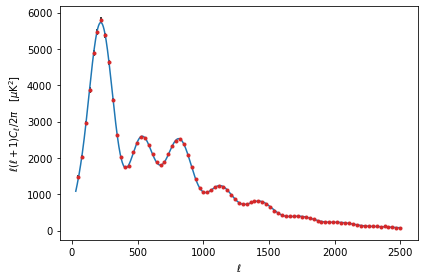

In [210]:
best_fit_TT = get_camb_spectra(
    ombh2=thinned_sample_params[max_lik_idx]["ombh2"],
    omch2=thinned_sample_params[max_lik_idx]["omch2"],
    cosmomctheta100=thinned_sample_params[max_lik_idx]["thetamc100"],
    tau=thinned_sample_params[max_lik_idx]["tau"],
    ns=thinned_sample_params[max_lik_idx]["ns"],
    ln1e10As=thinned_sample_params[max_lik_idx]["ln1e10As"],
)

dff  = pd.read_csv("plot/COM_PowerSpect_CMB-TT-binned.csv")
y_errormin =dff['mdDl']
y_errormax =dff['pdDl']
yerr =[y_errormin, y_errormax]

plt.figure(figsize=[6, 4])
plt.errorbar(dff['l'], dff['Dl'], yerr,fmt ='.', capsize=0, c="tab:red", ecolor="k")
plt.plot(np.arange(30, 2509), best_fit_TT[30:], "tab:blue")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell = \ell(\ell+1)C_\ell/2\pi \quad [\mu \mathrm{K}^2]$")
plt.tight_layout()
plt.show()